# 📈 LSTM 은퇴 시기 예측 (2-Layer LSTM + Dropout + 시각화)
이 노트북은 LSTM 모델을 사용하여 선수의 시즌 데이터를 기반으로 은퇴까지 남은 연도 수를 예측합니다.
- ✅ 2-layer LSTM + Dropout 적용
- ✅ 30 epoch 학습
- ✅ 예측 결과 시각화 포함

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 데이터 불러오기
df = pd.read_excel('kbo_retired_with_retire_season.xlsx')
features = ['AVG', 'SLG', 'OBP', 'G', 'AB', 'R', 'H', 'HR', 'RBI']
df[features] = df[features].replace('-', np.nan)
df = df.dropna(subset=features + ['season', 'name', 'birth_year'])
df[['AVG', 'SLG', 'OBP']] = df[['AVG', 'SLG', 'OBP']].astype(float)
df['years_until_retirement'] = df['retire_season'] - df['season']
df = df[df['years_until_retirement'] >= 0]
df['age'] = df['season'] - df['birth_year']
df['career_length'] = df.groupby('name')['season'].transform('count')
df = df.sort_values(['name', 'season'])
df['avg_diff'] = df.groupby('name')['AVG'].diff()
df['slg_diff'] = df.groupby('name')['SLG'].diff()
df['obp_diff'] = df.groupby('name')['OBP'].diff()
df = df.dropna(subset=['avg_diff', 'slg_diff', 'obp_diff'])
full_features = features + ['age', 'career_length', 'avg_diff', 'slg_diff', 'obp_diff']
scaler = MinMaxScaler()
df[full_features] = scaler.fit_transform(df[full_features])

In [3]:
# 시계열 시퀀스 구성
sequence_length = 5
sequences, targets = [], []
for player, group in df.groupby('name'):
    if len(group) < sequence_length:
        continue
    group = group.sort_values('season')
    for i in range(len(group) - sequence_length):
        seq = group.iloc[i:i+sequence_length][full_features].values
        target = group.iloc[i+sequence_length]['years_until_retirement']
        sequences.append(seq)
        targets.append(target)
X = np.array(sequences, dtype=np.float32)
y = np.array(targets, dtype=np.float32)

In [4]:
# Dataset 및 모델 정의
class PlayerDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)
        self.y = torch.tensor(y).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])

In [5]:
# 학습 및 평가
split = int(len(X) * 0.8)
train_ds = PlayerDataset(X[:split], y[:split])
test_ds = PlayerDataset(X[split:], y[split:])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size=X.shape[2]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(30):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 2024.7162
Epoch 2, Loss: 1677.6940
Epoch 3, Loss: 1333.3517
Epoch 4, Loss: 1110.9883
Epoch 5, Loss: 1078.4601
Epoch 6, Loss: 1049.4736
Epoch 7, Loss: 1034.8455
Epoch 8, Loss: 1033.2253
Epoch 9, Loss: 1040.0260
Epoch 10, Loss: 1068.1617
Epoch 11, Loss: 1027.8541
Epoch 12, Loss: 1008.4997
Epoch 13, Loss: 1018.8240
Epoch 14, Loss: 1044.8137
Epoch 15, Loss: 1016.8826
Epoch 16, Loss: 996.5159
Epoch 17, Loss: 981.1000
Epoch 18, Loss: 970.7375
Epoch 19, Loss: 982.2111
Epoch 20, Loss: 965.8451
Epoch 21, Loss: 952.4489
Epoch 22, Loss: 970.8742
Epoch 23, Loss: 954.2721
Epoch 24, Loss: 936.1955
Epoch 25, Loss: 942.3670
Epoch 26, Loss: 939.5334
Epoch 27, Loss: 974.1394
Epoch 28, Loss: 939.4866
Epoch 29, Loss: 948.4747
Epoch 30, Loss: 937.0905


{'MSE': 6.3401336669921875, 'MAE': 1.5107195377349854, 'R2': 0.5209218859672546}


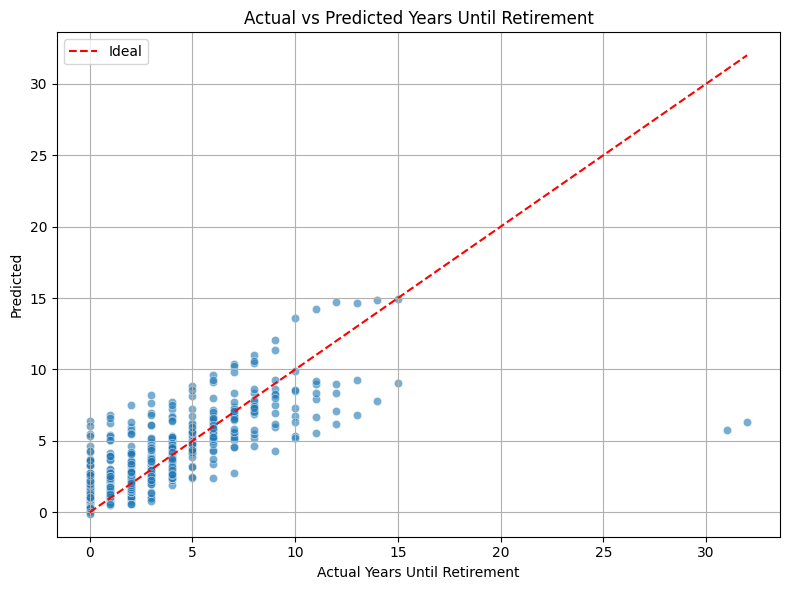

In [6]:
# 예측 및 시각화
model.eval()
preds, actuals = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()
        preds.append(pred)
        actuals.append(yb.numpy())

preds = np.vstack(preds).flatten()
actuals = np.vstack(actuals).flatten()

mse = mean_squared_error(actuals, preds)
mae = mean_absolute_error(actuals, preds)
r2 = r2_score(actuals, preds)
print({'MSE': mse, 'MAE': mae, 'R2': r2})

plt.figure(figsize=(8, 6))
sns.scatterplot(x=actuals, y=preds, alpha=0.6)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', label='Ideal')
plt.xlabel('Actual Years Until Retirement')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Years Until Retirement')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Best Params: {'hidden_size': 160, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.001, 'epochs': 50}

Top 5 parameter combinations by score:
hidden=160, layers=2, dropout=0.2, lr=0.001, epoch=50, score=3.7497
hidden=96, layers=2, dropout=0.2, lr=0.0007, epoch=50, score=3.7817
hidden=64, layers=2, dropout=0.3, lr=0.001, epoch=40, score=3.7984
hidden=96, layers=2, dropout=0.2, lr=0.001, epoch=40, score=3.8098
hidden=128, layers=2, dropout=0.1, lr=0.001, epoch=40, score=3.8319


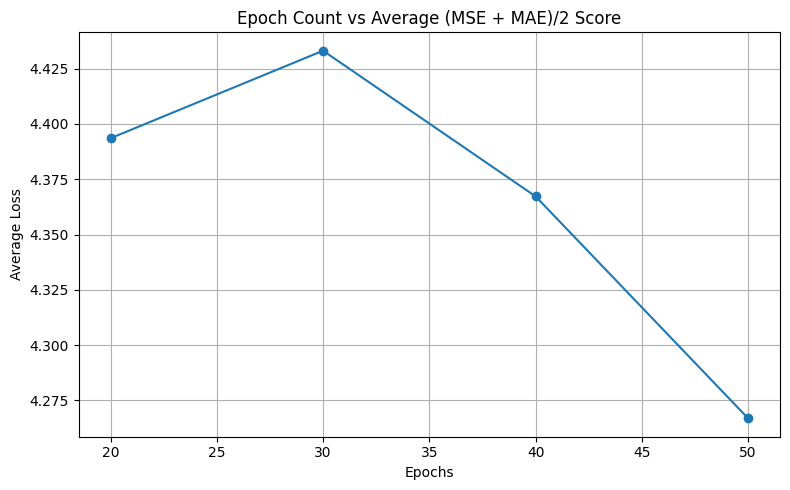

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# (이전 전처리 코드는 동일하다고 가정)

# 고급 파라미터 그리드 설정
param_grid = {
    'hidden_size': [64, 96, 128, 160],
    'num_layers': [2],  # dropout 적용 가능하도록 2 이상 고정
    'dropout': [0.0, 0.1, 0.2, 0.3],
    'lr': [0.001, 0.0007, 0.0003],
    'epochs': [20, 30, 40, 50]
}

# 성능 기록
results = []
best_score = float('inf')
best_params = {}
epoch_score_log = {}

for hs, nl, do, lr, ep in itertools.product(
    param_grid['hidden_size'],
    param_grid['num_layers'],
    param_grid['dropout'],
    param_grid['lr'],
    param_grid['epochs']):

    model = LSTMModel(input_size=X.shape[2], hidden_size=hs, num_layers=nl, dropout=do).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(ep):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad(); loss.backward(); optimizer.step()

    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            preds.append(pred)
            actuals.append(yb.numpy())

    preds = np.vstack(preds).flatten()
    actuals = np.vstack(actuals).flatten()
    mse = mean_squared_error(actuals, preds)
    mae = mean_absolute_error(actuals, preds)
    score = (mse + mae) / 2
    results.append((hs, nl, do, lr, ep, score))

    if ep not in epoch_score_log:
        epoch_score_log[ep] = []
    epoch_score_log[ep].append(score)

    if score < best_score:
        best_score = score
        best_params = {'hidden_size': hs, 'num_layers': nl, 'dropout': do, 'lr': lr, 'epochs': ep}

print("Best Params:", best_params)

# 결과 상위 5개 출력
print("\nTop 5 parameter combinations by score:")
for r in sorted(results, key=lambda x: x[-1])[:5]:
    print(f"hidden={r[0]}, layers={r[1]}, dropout={r[2]}, lr={r[3]}, epoch={r[4]}, score={r[5]:.4f}")

# Epoch vs Score 시각화
avg_epoch_scores = {k: np.mean(v) for k, v in epoch_score_log.items()}

plt.figure(figsize=(8, 5))
plt.plot(sorted(avg_epoch_scores.keys()), [avg_epoch_scores[k] for k in sorted(avg_epoch_scores.keys())], marker='o')
plt.title("Epoch Count vs Average (MSE + MAE)/2 Score")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1: Val MSE = 12.9074
Epoch 2: Val MSE = 8.9796
Epoch 3: Val MSE = 8.2436
Epoch 4: Val MSE = 6.8444
Epoch 5: Val MSE = 8.1566
Epoch 6: Val MSE = 8.3651
Epoch 7: Val MSE = 6.6085
Epoch 8: Val MSE = 7.7509
Epoch 9: Val MSE = 6.9467
Epoch 10: Val MSE = 6.9489
Epoch 11: Val MSE = 9.9317
Epoch 12: Val MSE = 8.0135
Early stopping at epoch 12
{'MSE': 6.6084771156311035, 'MAE': 1.48392915725708, 'R2': 0.500645101070404}


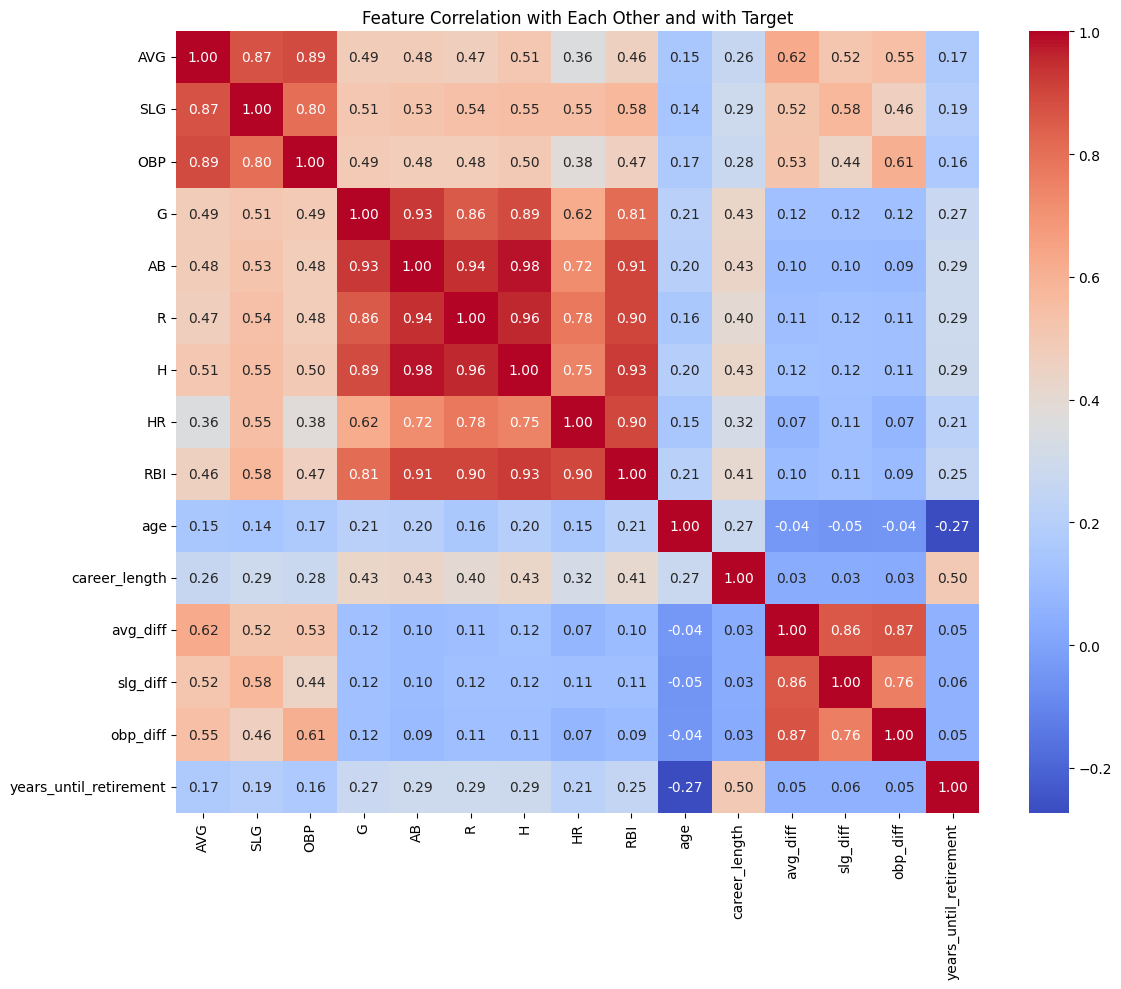

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. 데이터 로딩 및 전처리
df = pd.read_excel("kbo_retired_with_retire_season.xlsx")
features = ['AVG', 'SLG', 'OBP', 'G', 'AB', 'R', 'H', 'HR', 'RBI']
df[features] = df[features].replace('-', np.nan)
df = df.dropna(subset=features + ['season', 'name', 'birth_year'])
df[['AVG', 'SLG', 'OBP']] = df[['AVG', 'SLG', 'OBP']].astype(float)
df['years_until_retirement'] = df['retire_season'] - df['season']
df = df[df['years_until_retirement'] >= 0]
df['age'] = df['season'] - df['birth_year']
df['career_length'] = df.groupby('name')['season'].transform('count')
df = df.sort_values(['name', 'season'])
df['avg_diff'] = df.groupby('name')['AVG'].diff()
df['slg_diff'] = df.groupby('name')['SLG'].diff()
df['obp_diff'] = df.groupby('name')['OBP'].diff()
df = df.dropna(subset=['avg_diff', 'slg_diff', 'obp_diff'])

full_features = features + ['age', 'career_length', 'avg_diff', 'slg_diff', 'obp_diff']
scaler = MinMaxScaler()
df[full_features] = scaler.fit_transform(df[full_features])

# 2. 시계열 시퀀스 생성
sequence_length = 5
sequences, targets = [], []
for player, group in df.groupby('name'):
    if len(group) < sequence_length:
        continue
    group = group.sort_values('season')
    for i in range(len(group) - sequence_length):
        seq = group.iloc[i:i+sequence_length][full_features].values
        target = group.iloc[i+sequence_length]['years_until_retirement']
        sequences.append(seq)
        targets.append(target)

X = np.array(sequences, dtype=np.float32)
y = np.array(targets, dtype=np.float32)

# 3. Dataset, Model 정의
class PlayerDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)
        self.y = torch.tensor(y).unsqueeze(1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])

# 4. 데이터 분할 및 모델 설정
split = int(len(X) * 0.8)
train_ds = PlayerDataset(X[:split], y[:split])
test_ds = PlayerDataset(X[split:], y[split:])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_params = {
    'hidden_size': 160,
    'num_layers': 2,
    'dropout': 0.2,
    'lr': 0.001,
    'epochs': 300
}

# 5. 모델 학습 (EarlyStopping 포함)
final_model = LSTMModel(
    input_size=X.shape[2],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
).to(device)

optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['lr'])
criterion = nn.MSELoss()

best_val_loss = float('inf')
patience = 5
counter = 0
best_model_state = None

for epoch in range(best_params['epochs']):
    final_model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = final_model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    final_model.eval()
    val_preds, val_actuals = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = final_model(xb).cpu().numpy()
            val_preds.append(pred)
            val_actuals.append(yb.numpy())

    val_preds = np.vstack(val_preds).flatten()
    val_actuals = np.vstack(val_actuals).flatten()
    val_loss = mean_squared_error(val_actuals, val_preds)
    print(f"Epoch {epoch+1}: Val MSE = {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(final_model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

final_model.load_state_dict(best_model_state)

# 6. 예측 및 저장
final_model.eval()
preds, actuals = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = final_model(xb).cpu().numpy()
        preds.append(pred)
        actuals.append(yb.numpy())

preds = np.vstack(preds).flatten()
actuals = np.vstack(actuals).flatten()

os.makedirs("models", exist_ok=True)
torch.save(final_model.state_dict(), "models/best_lstm_model.pt")

result_df = pd.DataFrame({"actual_years_until_retirement": actuals, "predicted": preds})
result_df.to_csv("prediction_results.csv", index=False)

# 7. 성능 지표 출력
mse = mean_squared_error(actuals, preds)
mae = mean_absolute_error(actuals, preds)
r2 = r2_score(actuals, preds)
print({'MSE': mse, 'MAE': mae, 'R2': r2})

# 8. 상관관계 히트맵
corr = df[full_features + ['years_until_retirement']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation with Each Other and with Target")
plt.tight_layout()
plt.show()
